<a href="https://colab.research.google.com/github/sharjat94/Weatherwise-SharjatBinKarim/blob/main/starter_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installing all the necessary Packages


In [ ]:
# installing necessary packages
!pip install pyinputplus
!pip install fetch-my-weather
!pip install hands-on-ai
!pip install matplotlib requests

In [ ]:
import requests
import matplotlib.pyplot as plt
import pyinputplus as pyip
from fetch_my_weather import get_weather
from hands_on_ai.chat import get_response

## 🌤️ Weather Data Functions

In [ ]:
def get_weather_data(location, forecast_days=5):
    """
    Retrieve weather data for a specified location using the wttr.in API.

    Args:
        location (str): City or location name (e.g. "Perth", "London").
        forecast_days (int): Number of forecast days to return (1-5 max recommended to avoid overload).

    Returns:
        dict: Weather data including current conditions and forecast.
              Returns None if an error occurs.
    """
    url = f"https://wttr.in/{location}?format=j1"

    try:
        response = requests.get(url, timeout=10)
        response.raise_for_status()  # Ensures HTTP error codes are caught

        data = response.json()

        # Limit forecast to specified number of days if available
        if "weather" in data:
            data["weather"] = data["weather"][:forecast_days]
        else:
            print("⚠ Unexpected response structure: 'weather' key missing.")
            return None

        return data

    except requests.exceptions.RequestException as api_error:
        print(f"❌ Network/API error occurred: {api_error}")
        return None
    except ValueError as data_error:
        print(f"⚠ Error while processing data: {data_error}")
        return None
    except Exception as unexpected_error:
        print(f"⚠ An unexpected error occurred: {unexpected_error}")
        return None


## 📊 Visualisation Functions

In [14]:
def create_temperature_visualisation(weather_data, output_type='display'):
    dates = [day['date'] for day in weather_data['weather']]
    max_temps = [int(day['maxtempC']) for day in weather_data['weather']]
    min_temps = [int(day['mintempC']) for day in weather_data['weather']]

    plt.figure(figsize=(8,5))
    plt.plot(dates, max_temps, 'r-o', label='Max Temp')
    plt.plot(dates, min_temps, 'b-o', label='Min Temp')
    plt.xlabel("Date")
    plt.ylabel("Temperature (°C)")
    plt.title("Temperature Forecast")
    plt.legend()
    plt.grid(True)
    if output_type == 'display':
        plt.show()
    else:
        return plt.gcf()

In [ ]:
def create_precipitation_visualisation(weather_data, output_type='display'):
    dates = [day['date'] for day in weather_data['weather']]
    avg_precip = [
        sum(float(hour.get('precipMM',0)) for hour in day.get('hourly',[])) / len(day.get('hourly',[]))
        for day in weather_data['weather']
    ]

    plt.figure(figsize=(8,5))
    plt.bar(dates, avg_precip, color='skyblue')
    plt.xlabel("Date")
    plt.ylabel("Avg Precipitation (mm)")
    plt.title("Precipitation Forecast")
    plt.grid(True)
    if output_type == 'display':
        plt.show()
    else:
        return plt.gcf()

In [ ]:
def plot_temp_rain_combo(weather_data):
    dates = [day['date'] for day in weather_data['weather']]
    max_temps = [int(day['maxtempC']) for day in weather_data['weather']]
    min_temps = [int(day['mintempC']) for day in weather_data['weather']]
    avg_precip = [
        sum(float(hour.get('precipMM',0)) for hour in day.get('hourly',[])) / len(day.get('hourly',[]))
        for day in weather_data['weather']
    ]

    fig, ax1 = plt.subplots(figsize=(10,5))
    ax1.set_xlabel("Date")
    ax1.set_ylabel("Temperature (°C)", color='tab:red')
    ax1.plot(dates, max_temps, 'r-o', label='Max Temp')
    ax1.plot(dates, min_temps, 'orange', linestyle='--', marker='o', label='Min Temp')
    ax1.tick_params(axis='y', labelcolor='tab:red')
    ax1.legend(loc='upper left')

    ax2 = ax1.twinx()
    ax2.set_ylabel("Avg Precipitation (mm)", color='tab:blue')
    ax2.bar(dates, avg_precip, alpha=0.3, color='tab:blue', label='Avg Precipitation')
    ax2.tick_params(axis='y', labelcolor='tab:blue')
    ax2.legend(loc='upper right')

    plt.title("Temperature and Precipitation Forecast")
    plt.show()


In [15]:
def display_temperature_chart(weather_data):
    """
    Display a line chart for Max and Min temperatures.
    Args:
        weather_data (dict): Weather data dictionary from get_weather_data()
    """
    # Extract dates and temperatures
    dates = [day['date'] for day in weather_data['weather']]
    max_temps = [int(day['maxtempC']) for day in weather_data['weather']]
    min_temps = [int(day['mintempC']) for day in weather_data['weather']]

    # Create the plot
    plt.figure(figsize=(10,5))
    plt.plot(dates, max_temps, marker='o', color='red', label='Max Temp (°C)')
    plt.plot(dates, min_temps, marker='o', color='blue', label='Min Temp (°C)')

    # Fill the area between min and max for better visualization
    plt.fill_between(dates, min_temps, max_temps, color='lightgray', alpha=0.5)

    # Add labels and title
    plt.xlabel("Date")
    plt.ylabel("Temperature (°C)")
    plt.title("Daily Temperature Range Forecast")
    plt.legend()
    plt.grid(True)
    plt.show()

## 🤖 Natural Language Processing

In [ ]:
def parse_weather_question_nlp(question):
    """
    Parse a natural language weather question to extract location, time, and attribute.
    """
    question_lower = question.lower()

    perth_areas = ["perth", "fremantle", "cannington", "joondalup", "subiaco", "victoria park"]
    location = "Perth"  # default
    for area in perth_areas:
        if area in question_lower:
            location = area.title()
            break
    else:

        words = question.split()
        location = words[-1].title() if len(words) > 1 else "Unknown"


    if "tomorrow" in question_lower:
        time_period = "tomorrow"
    elif "day after tomorrow" in question_lower:
        time_period = "day after tomorrow"
    elif "next" in question_lower and "day" in question_lower:
        time_period = "next few days"
    else:
        time_period = "today"


    if any(word in question_lower for word in ["temperature", "hot", "cold"]):
        attribute = "temperature"
    elif any(word in question_lower for word in ["rain", "precipitation", "shower"]):
        attribute = "precipitation"
    elif "humidity" in question_lower:
        attribute = "humidity"
    elif "wind" in question_lower or "breeze" in question_lower:
        attribute = "wind"
    else:
        attribute = "general"

    return {
        "location": location,
        "time_period": time_period,
        "attribute": attribute
    }


## 🧭 User Interface

In [ ]:
def main_menu():
    print("🌤️ Welcome to Weather Advisor!")
    while True:
        print("\nPlease choose an option:")
        print("1 - View Today's Weather")
        print("2 - Ask a Weather Question")
        print("3 - Display Temperature Graph")
        print("4 - Display Rain/Precipitation Graph")
        print("5 - Display Combination of Temperature and Rain Graph")
        print("6 - Quit")

        choice = pyip.inputChoice(['1','2','3','4','5','6'], prompt="Enter choice (1-6): ")

        if choice == '6':
            print("Goodbye! 👋")
            break

        location = pyip.inputStr(prompt="Enter location (city or Perth area): ")
        weather_data = get_weather_data(location, forecast_days=3)
        if not weather_data:
            print("⚠ Could not retrieve weather data. Please try again.")
            continue

        if choice == '1':
            response = generate_weather_response({
                'location': location,
                'attribute': None,
                'time_period': 'today'
            }, weather_data)
            print(response)

        elif choice == '2':
            question = pyip.inputStr(prompt="Ask your weather question: ")
            parsed = parse_weather_question(question)
            parsed['location'] = location
            response = generate_weather_response(parsed, weather_data)
            print(response)

        elif choice == '3':
            create_temperature_visualisation(weather_data)

        elif choice == '4':
            create_precipitation_visualisation(weather_data)

        elif choice == '5':
            plot_temp_rain_combo(weather_data)


## 🧩 Main Application Logic

In [ ]:
def main_menu():
    print("🌤️ Welcome to Weather Advisor!")

    while True:
        print("\nPlease choose an option:")
        print("1 - View Today's Weather")
        print("2 - Ask a Weather Question")
        print("3 - Display Temperature Graph")
        print("4 - Display Rain/Precipitation Graph")
        print("5 - Display Combination of Temperature and Rain Graph")
        print("6 - Chat with Weather Advisor (NLP)")
        print("7 - Quit")

        choice = pyip.inputChoice(['1','2','3','4','5','6','7'], prompt="Enter choice (1-7): ")

        if choice == '7':
            print("Goodbye! 👋")
            break


        location = None
        if choice != '6':
            location = pyip.inputStr(prompt="Enter location (city or Perth area): ")


        if choice == '1':
            weather_data = get_weather_data(location, forecast_days=3)
            if not weather_data:
                print("⚠ Could not retrieve weather data. Please try again.")
                continue
            response = generate_weather_response({
                'location': location,
                'attribute': None,
                'time_period': 'today'
            }, weather_data)
            print(response)


        elif choice == '2':
            question = pyip.inputStr(prompt="Ask your weather question: ")
            parsed = parse_weather_question_nlp(question)
            parsed['location'] = location
            weather_data = get_weather_data(location, forecast_days=3)
            if not weather_data:
                print(f"⚠ Could not retrieve weather data for {location}.")
                continue
            response = generate_weather_response(parsed, weather_data)
            print(response)


        elif choice == '3':
            weather_data = get_weather_data(location, forecast_days=3)
            if not weather_data:
                print(f"⚠ Could not retrieve weather data for {location}.")
                continue
            create_temperature_visualisation(weather_data)


        elif choice == '4':
            weather_data = get_weather_data(location, forecast_days=3)
            if not weather_data:
                print(f"⚠ Could not retrieve weather data for {location}.")
                continue
            create_precipitation_visualisation(weather_data)


        elif choice == '5':
            weather_data = get_weather_data(location, forecast_days=3)
            if not weather_data:
                print(f"⚠ Could not retrieve weather data for {location}.")
                continue
            plot_temp_rain_combo(weather_data)


        elif choice == '6':
            print("🤖 Enter your question about the weather (type 'exit' to return to menu).")
            while True:
                question = pyip.inputStr(prompt="You: ")
                if question.lower() in ["exit", "quit"]:
                    print("Returning to main menu...")
                    break
                parsed = parse_weather_question_nlp(question)
                weather_data = get_weather_data(parsed['location'], forecast_days=3)
                if not weather_data:
                    print(f"⚠ Could not retrieve weather data for {parsed['location']}.")
                    continue
                response = generate_weather_response(parsed, weather_data)
                print("🤖", response)

## 🧪 Testing and Examples

In [ ]:
# Test fetching weather data for Perth for the next 3 days
weather_perth = get_weather_data("Perth", forecast_days=3)
print(weather_perth.keys())
print(weather_perth['weather'][0])


dict_keys(['current_condition', 'nearest_area', 'request', 'weather'])
{'astronomy': [{'moon_illumination': '6', 'moon_phase': 'Waning Crescent', 'moonrise': '04:13 AM', 'moonset': '04:35 PM', 'sunrise': '05:33 AM', 'sunset': '06:31 PM'}], 'avgtempC': '16', 'avgtempF': '60', 'date': '2025-10-19', 'hourly': [{'DewPointC': '9', 'DewPointF': '49', 'FeelsLikeC': '16', 'FeelsLikeF': '61', 'HeatIndexC': '16', 'HeatIndexF': '61', 'WindChillC': '16', 'WindChillF': '61', 'WindGustKmph': '16', 'WindGustMiles': '10', 'chanceoffog': '0', 'chanceoffrost': '0', 'chanceofhightemp': '0', 'chanceofovercast': '84', 'chanceofrain': '81', 'chanceofremdry': '0', 'chanceofsnow': '0', 'chanceofsunshine': '0', 'chanceofthunder': '0', 'chanceofwindy': '0', 'cloudcover': '98', 'diffRad': '0.0', 'humidity': '64', 'precipInches': '0.0', 'precipMM': '0.0', 'pressure': '1010', 'pressureInches': '30', 'shortRad': '0.0', 'tempC': '16', 'tempF': '61', 'time': '0', 'uvIndex': '0', 'visibility': '10', 'visibilityMiles':

In [ ]:
main_menu()

🌤️ Welcome to Weather Advisor!

Please choose an option:
1 - View Today's Weather
2 - Ask a Weather Question
3 - Display Temperature Graph
4 - Display Rain/Precipitation Graph
5 - Display Combination of Temperature and Rain Graph
6 - Chat with Weather Advisor (NLP)
7 - Quit
Enter choice (1-7): 1
Enter location (city or Perth area): fremantle
I received your request for None in fremantle for today. The weather data is available.

Please choose an option:
1 - View Today's Weather
2 - Ask a Weather Question
3 - Display Temperature Graph
4 - Display Rain/Precipitation Graph
5 - Display Combination of Temperature and Rain Graph
6 - Chat with Weather Advisor (NLP)
7 - Quit
Enter choice (1-7): 2
Enter location (city or Perth area): fremantle
Ask your weather question: whats the temperature in fremantle?
I received your request for temperature in fremantle for today. The weather data is available.

Please choose an option:
1 - View Today's Weather
2 - Ask a Weather Question
3 - Display Tempera

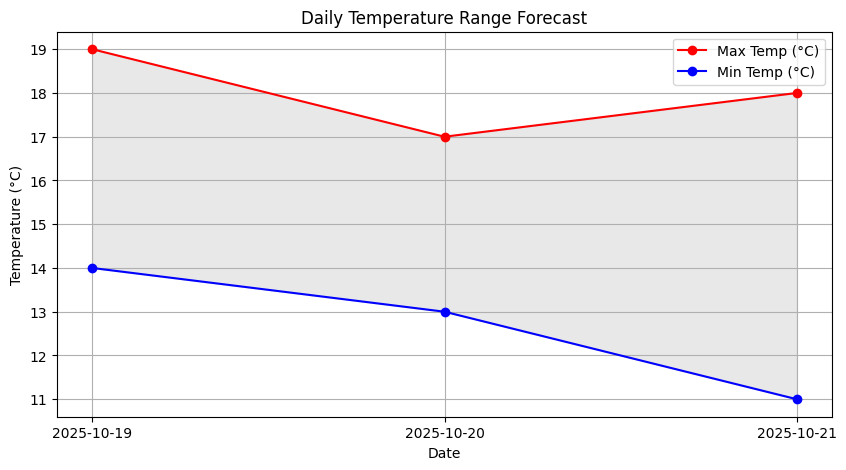

In [18]:
# Test the display_temperature_chart function with the weather_perth data
if 'weather_perth' in locals():
    display_temperature_chart(weather_perth)
else:
    print("The 'weather_perth' variable is not available. Please run the cell to fetch weather data first.")

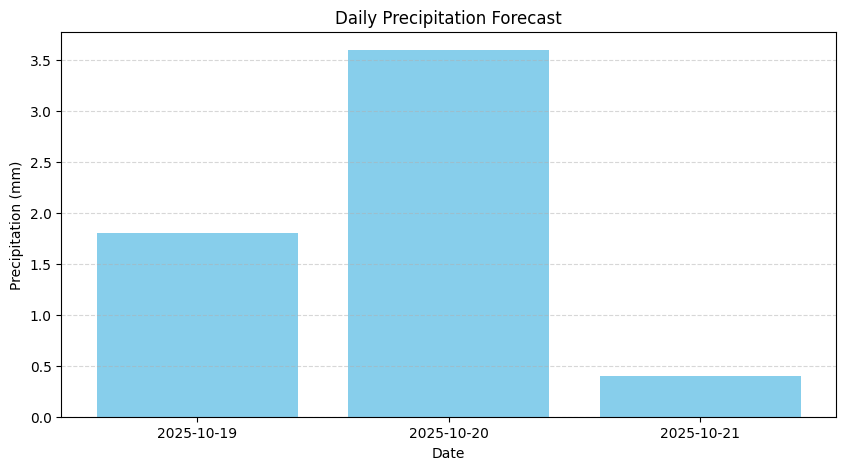

In [16]:
def display_precipitation_chart(weather_data):
    """
    Display a bar chart showing daily precipitation (rain) for the forecasted days.

    Args:
        weather_data (dict): Weather data dictionary from get_weather_data()
    """
    # Extract dates and total daily precipitation
    dates = [day['date'] for day in weather_data['weather']]
    precipitation = [sum(float(hour['precipMM']) for hour in day['hourly']) for day in weather_data['weather']]

    # Create bar chart
    plt.figure(figsize=(10,5))
    plt.bar(dates, precipitation, color='skyblue')

    # Titles and labels
    plt.title("Daily Precipitation Forecast")
    plt.xlabel("Date")
    plt.ylabel("Precipitation (mm)")
    plt.grid(axis='y', linestyle='--', alpha=0.5)

    # Show chart
    plt.show()

# Example usage:
weather_perth = get_weather_data("Perth", forecast_days=5)
display_precipitation_chart(weather_perth)


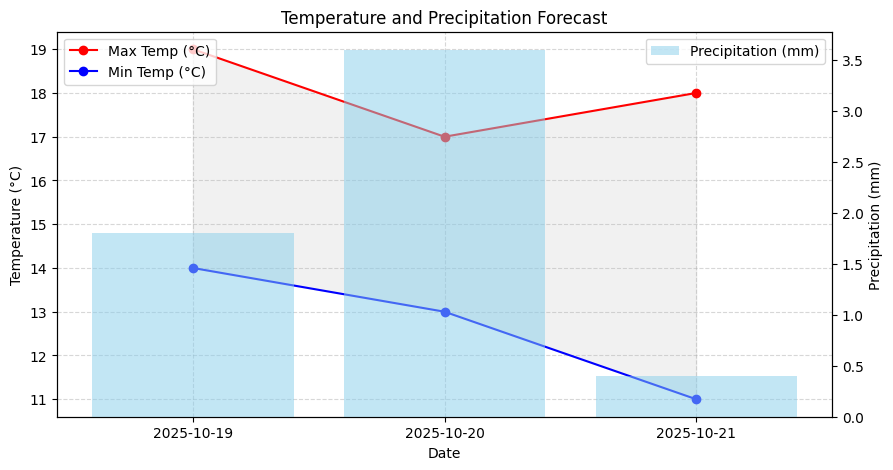

In [17]:
def display_temp_rain_combo(weather_data):
    """
    Display a combined chart with temperature (line) and precipitation (bar).

    Args:
        weather_data (dict): Weather data dictionary from get_weather_data()
    """
    # Extract data
    dates = [day['date'] for day in weather_data['weather']]
    max_temps = [int(day['maxtempC']) for day in weather_data['weather']]
    min_temps = [int(day['mintempC']) for day in weather_data['weather']]
    precipitation = [sum(float(hour['precipMM']) for hour in day['hourly']) for day in weather_data['weather']]

    # Create figure and primary axis
    fig, ax1 = plt.subplots(figsize=(10,5))

    # Temperature lines
    ax1.plot(dates, max_temps, marker='o', color='red', label='Max Temp (°C)')
    ax1.plot(dates, min_temps, marker='o', color='blue', label='Min Temp (°C)')
    ax1.fill_between(dates, min_temps, max_temps, color='lightgray', alpha=0.3)
    ax1.set_xlabel("Date")
    ax1.set_ylabel("Temperature (°C)")
    ax1.legend(loc='upper left')
    ax1.grid(True, linestyle='--', alpha=0.5)

    # Precipitation bars on secondary axis
    ax2 = ax1.twinx()
    ax2.bar(dates, precipitation, color='skyblue', alpha=0.5, label='Precipitation (mm)')
    ax2.set_ylabel("Precipitation (mm)")
    ax2.legend(loc='upper right')

    # Title
    plt.title("Temperature and Precipitation Forecast")

    # Show chart
    plt.show()

# Example usage:
weather_perth = get_weather_data("Perth", forecast_days=5)
display_temp_rain_combo(weather_perth)


## 🗂️ AI Prompting Log (Optional)
Add markdown cells here summarising prompts used or link to AI conversations in the `ai-conversations/` folder.